<h1 align='center'>Deteccion de anomalías en grandes volúmenes de datos</h1>


## Análisis del dataset

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab

In [10]:
df = pd.read_csv('creditcard.csv')

In [11]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ahora determinamos la cantidad de transacciones fraudulentas en el dataset.

In [12]:
frauds = (df['Class'] == 1)

In [13]:
len(df[frauds])

492

In [14]:
len(df)

284807

Lo anterior nos indica que de las $284,807$ transacciones en el dataset, $492$ corresponden a transacciones fraudulentas, de modo que el resto de transacciones, $284,315$, son transacciones normales. Podemos visualizar esto en un gráfico de pastel.

<AxesSubplot:>

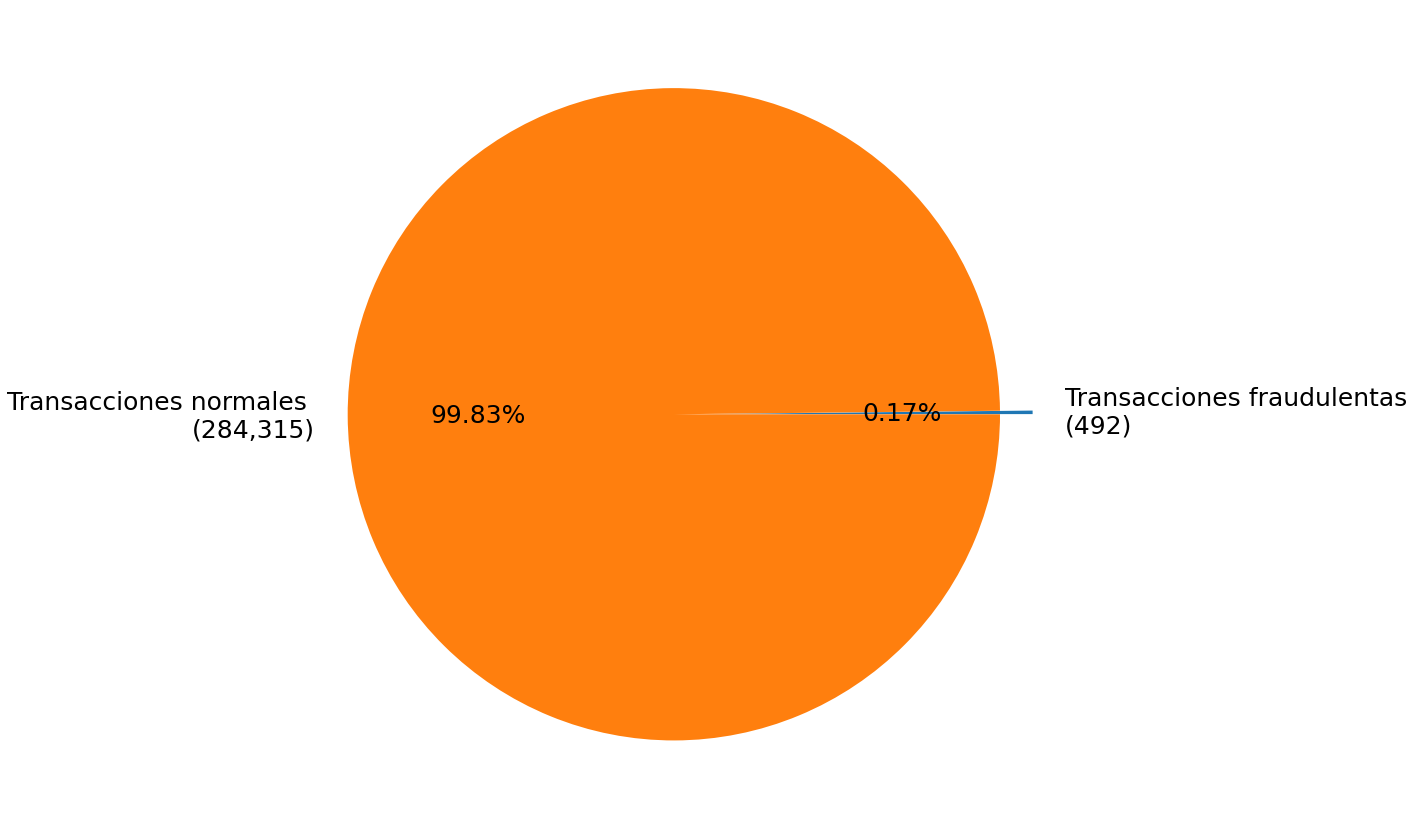

In [17]:
plot_data = pd.DataFrame({ 'Tipo de transacción': ['Transacciones fraudulentas \n(492)', 'Transacciones normales \n(284,315)'],
                  'Cantidad': [492, 284315]})

plot_data.set_index('Tipo de transacción', inplace=True)
plot = plot_data.plot.pie(y='Cantidad', legend=False, \
                   autopct='%1.2f%%', explode=(0, 0.1), \
                   shadow=False, startangle=0, figsize=(15, 15), fontsize=25);
pylab.ylabel('')
plot

Podemos verificar que en este dataset no hay datos nulos:

In [18]:
df.isnull().values.any()

False

In [19]:
df.isnull().sum().sum()

0

## Matriz de correlación

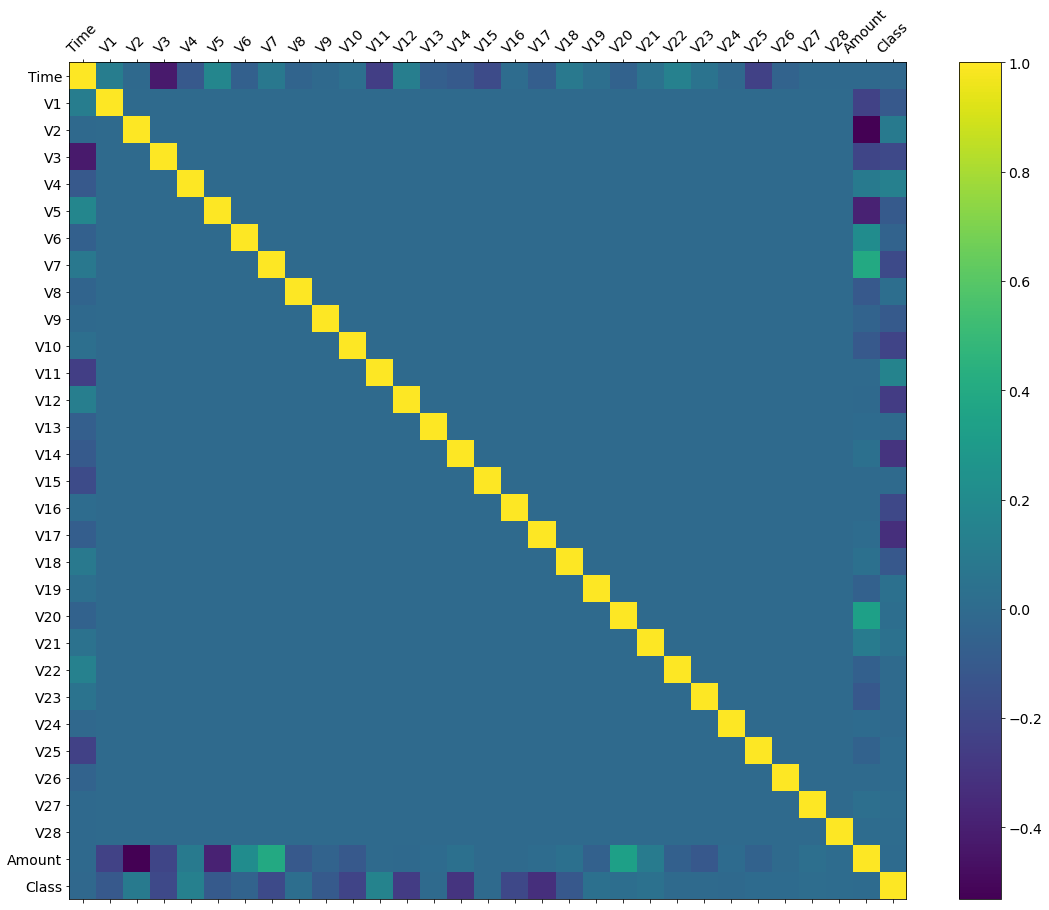

In [27]:
f = plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)